# Table of contents
1. [Dataset Parsing](#vocab)
2. [Quantum Circuits](#circuit)
3. [Process Dataset](#dataset)
4. [Optimization](#optimization)
5. [Results](#results)

# Sentiment analysis

Sentiment analysis is a natural language processing (NLP) technique to determine the sentiment of a sentence. In this implementation, we propose to use quantum natural language processing (QNLP) as an alternative to solve this problem. QNLP enables the resolution of NLP tasks taking advantage of the inherent quantum nature of language, allowing to take into account the grammar of sentences and to work in an exponentially large Hilbert space, easing the memory problems of its classical counterpart.

In this Jupyter Notebook we show how to solve a sentiment analysis problem. More concretely, it is a multi-class classification task where the sentences of a dataset are divided into four categories: happy, sad, angry and scared. As a reference for the resolution of this problem we use the paper by Lorenz et al https://arxiv.org/abs/2102.12846, where they solve a binary classification problem. Their code and resources can be found in https://github.com/CQCL/qnlp_lorenz_etal_2021_resources.

## 1. Parse Vocabulary and Grammar <a name="vocab"></a>


The first step is to create the dataset for our task. It is important to create a balanced dataset suitable for this problem. In order to do that, we have chosen the following words
 
| Nouns | Verbs | Adjectives |
| --- | --- | --- |
| Man | cries | morose |
| Woman | laughs | irascible |
| Kid | shouts | frightened |
|  | snaps | cheerful |
|  | entertains | gloomy |
|  | grieves | furious |
|  | startles | terrified |
|  | irritates |joyful|
|  |  | downcast|
|  |  | miserable|
|  |  | old|
|  |  | young|

We can observe that we have three different types of words: nouns, verbs and adjectives. The information regarding the meaning of the sentence is going to be given by the verb, the adjective or the combination of both, as there are verbs that can be used to express more than one feeling, or adjectives that show no sentiment ('young', 'old')

The proposed vocabulary has 23 words, with which we write 366 sentences, for example


- Morose man cries. (morose)
- Irascible woman shouts. (irascible)
- Frightened woman shouts. (frightened)
- Joyful kid laughs. (joyful, laughs)
- Furious man snaps. (furious)
- Kid startles man. (startles)
- Woman grieves man. (grieves)
...

The brackets indicate the word or words that enclose the sentiment in each example.

We are going to consider four classes of sentences:
- Adj + Subject + Intransitive verb
- Subject + Transitive verb + Object
- Adjective + Subject + Transitive verb + Object
- Subject + Transitive verb + Adjective + Object

The steps to construct the dataset are the following ones. We first store the words in DisCoPy's Word objects, encoding their meaning (name) and their grammar (codomain). Then, we introduce the grammar of the allowed sentences and create all the possible grammatical sentences. The next step is to assign a sentiment to each sentence. However, there are sentences that although they are grammatically correct, their meaning makes no sense, so we would have to remove them. 

### 1.1. Define the vocabulary

The first step to create a dataset is to define the words, their meaning and the word type. We have four three types of words: nouns, adjectives, verbs. We also distinguish two different types of verbs: transitive and intransitive. 

In [1]:
import numpy as np
import pickle

import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.2', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.3', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.4', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
from discopy import Ty, Word # Import the classes for the type of word and for the word

s, n = Ty('s'), Ty('n') # Define the types s and n

# Define the words (notice that we include both meaning and grammar)

# nouns
man, woman, kid = Word('man', n), Word('woman', n), Word('kid', n)
# adjectives
morose, irascible = Word('morose', n @ n.l), Word('irascible', n @ n.l)
frightened, cheerful = Word('frightened', n @ n.l), Word('cheerful', n @ n.l)
gloomy, furious = Word('gloomy', n @ n.l), Word('furious', n @ n.l)
terrified, joyful = Word('terrified', n @ n.l), Word('joyful', n @ n.l)
downcast, miserable = Word('downcast', n @ n.l), Word('miserable', n @ n.l)
old, young = Word('old', n @ n.l), Word('young', n @ n.l)
# Intransitive verbs
cries, shouts = Word('cries', n.r @ s), Word('shouts', n.r @ s)
laughs, snaps = Word('laughs', n.r @ s), Word('snaps', n.r @ s)
# Transitive verbs
grieves, startles = Word('grieves', n.r @ s @ n.l), Word('startles', n.r @ s @ n.l)
entertains, irritates = Word('entertains', n.r @ s @ n.l), Word('irritates', n.r @ s @ n.l)

nouns = [man, woman, kid]
adjectives = [morose, irascible, frightened, cheerful, gloomy, furious, terrified, joyful, downcast, miserable, old, young]
int_verbs = [cries, shouts, laughs, snaps]
t_verbs = [grieves, startles, entertains, irritates]

vocab = nouns + int_verbs + t_verbs + adjectives

### 1.2. Define the grammar

In this dataset we are going to consider the following structures to construct the sentences:

- adj + noun + int. verb
- noun + t. verb + noun
- adj + noun + t. verb + noun
- noun + t. verb + adj + noun

- Intransitive sentence

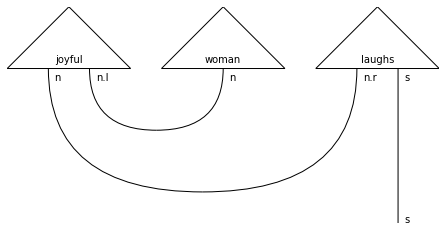

In [3]:
from discopy import Cup, Id, pregroup

grammar =  Id(n) @ Cup(n.l, n) @ Id(n.r @ s) >> Cup(n, n.r) @ Id(s) >> Id(s)
sentence = joyful @ woman @ laughs >> grammar
pregroup.draw(sentence)

- Transitive sentence

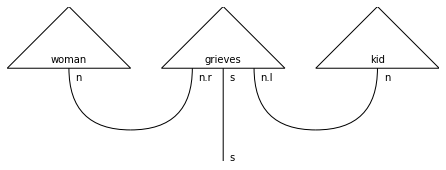

In [4]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
sentence = woman @ grieves @ kid >> grammar
pregroup.draw(sentence)

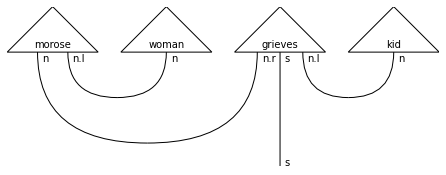

In [5]:
grammar =  Id(n) @ Cup(n.l, n) @ Id(n.r @ s) @ Cup(n.l, n) >> Cup(n, n.r) @ Id(s) >> Id(s)
sentence = morose @ woman @ grieves @ kid >> grammar
pregroup.draw(sentence)

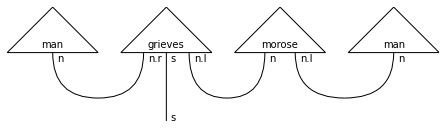

In [6]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n) >> Id(s)
sentence =  man @ grieves @ morose @ man >> grammar
pregroup.draw(sentence)

Now we have seen how the grammatical structure of each type of sentence is, so we are ready to obtain all the grammatical sentences that we can construct with them with the vocabulary that we are using. 

In [7]:
from discopy import Diagram
from discopy.grammar import draw

# Store the grammatical structures of each sentence type in a dictionary 

grammar_dict = {
    'ADJ_N_IV' : Id(n) @ Cup(n.l, n) @ Id(n.r @ s) >> Cup(n, n.r) @ Id(s) >> Id(s),
    'N_TV_N': Cup(n, n.r) @ Id(s) @ Cup(n.l, n),
    'ADJ_N_TV_N': Id(n) @ Cup(n.l, n) @ Id(n.r @ s) @ Cup(n.l, n) >> Cup(n, n.r) @ Id(s) >> Id(s),
    'N_TV_ADJ_N': Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n) >> Id(s)}
                                                                          

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)

data_psr = {}

#Creates all possible sentences

# Intransitive sentences
parsing_int = {"{} {} {}.".format(adj, noun, int_verb): adj @ noun @ int_verb >> grammar_dict['ADJ_N_IV']
            for adj in adjectives for noun in nouns for int_verb in int_verbs}
sentences_int = list(parsing_int.keys())
for sentence in sentences_int:
    diagram = parsing_int[sentence]
    data_psr[sentence] = parsing_int[sentence]

# Transitive sentences (without adjective)
parsing_tra = {"{} {} {}.".format(subj, t_verb, obj):  subj @ t_verb @ obj >> grammar_dict['N_TV_N']
            for subj in nouns for t_verb in t_verbs for obj in nouns}


# Transitive sentences (with adjective)
parsing_tra_ladj = {"{} {} {} {}.".format(adj, subj, t_verb, obj):  adj @ subj @ t_verb @ obj >> grammar_dict['ADJ_N_TV_N']
            for adj in adjectives for subj in nouns for t_verb in t_verbs for obj in nouns}
parsing_tra_radj = {"{} {} {} {}.".format(subj, t_verb, adj, obj):  subj @ t_verb @ adj @ obj >> grammar_dict['N_TV_ADJ_N']
            for subj in nouns for t_verb in t_verbs for adj in adjectives for obj in nouns}

parsing_tra.update(parsing_tra_ladj) #merges transitive adjectives into original dict
parsing_tra.update(parsing_tra_radj)

sentences_tra = list(parsing_tra.keys())
for sentence in sentences_tra:
    diagram = parsing_tra[sentence]
    data_psr[sentence] = parsing_tra[sentence]

Now, we have the dataset with the sentences and their corresponding meaning and grammar. We are aiming to distinguish between four different emotions: happy (0), sad (1), angry (2), scared (3). However, some sentences of the dataset cannot be clearly classified according to this criteria (for example, 'Old man shouts'). Therefore, the next step is to manually modify the dataset so all the sentences can be classified according to this criteria. In order to do that we will create a .txt file and assign the corresponding class to the viable sentences. The result is the sentiment_analysis_dataset.txt. 

### 1.3. Process the data

In [8]:
with open('../sentiment_analysis_dataset.txt') as f:
    data = f.readlines()

In [9]:
labels_dict = {} # Dictionary with the labels for each sentence
data_psr_dict = {} # Dictionary with the parsing for each sentence
sent_type = {} # Dictionary with the sentence type for each sentence


adjective_words = [a.name for a in adjectives]
for sentence in data:
    sentstr = sentence[:-7] #seperates the sentence string from the data at the end
    if sentence[-6:-3] == 'int':
        diagram = parsing_int[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        sent_type[sentstr] = 'int'
    elif sentence[-6:-3] == 'tra':
        diagram = parsing_tra[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]

        if len(sentstr.split()) == 4:
            if sentstr.split()[0] in adjective_words:
                sent_type[sentstr] = 'tra_' + 'l' #adjective on the left
            else:
                sent_type[sentstr] = 'tra_' + 'r' #adjective on the right
        else:
            sent_type[sentstr] = 'tra' #the simple transitive verb sentence type
            

In [10]:
c0 = 0
c1 = 0
c2 = 0
c3 = 0
for value in labels_dict.values():
    if value == '0':
        c0 +=1
    elif value == '1':
        c1 += 1
    elif value == '2':
        c2 += 1
    elif value == '3':
        c3 += 1
print('Number of elements for each sentiment')
print('Happy: ', c0)
print('Sad: ', c1)
print('Angry: ', c2)
print('Scared: ', c3)
print('Total', len(data_psr_dict))

Number of elements for each sentiment
Happy:  90
Sad:  96
Angry:  92
Scared:  87
Total 365


Now we have our dataset! The only problem left is the fact that the cups used in the diagrams are too resource consuming. Luckily, it is possible to remove them by transforming the states into effects (we are just doing this with the nouns as in https://github.com/CQCL/qnlp_lorenz_etal_2021_resources). Let us see some examples

In [11]:
from discopy import Cap, Box

In [16]:
# Code of this cell addapted from https://github.com/CQCL/qnlp_lorenz_etal_2021_resources
#iterates through all sentences and reshapes them as above according to their type

data_new_psr_dict = {}
for sentstr in data_psr_dict.keys(): 
    num_words = len(sentstr.split(' '))
    words = data_psr_dict[sentstr].boxes[:num_words]
    if sent_type[sentstr] == 'int':
        noun = Box(words[1].name, n.l, Ty())
        words_new = (Cap(n, n.l)) >> (words[0] @ Id(n) @ noun @ words[2])
        sentence = words_new >> grammar_dict['ADJ_N_IV']
        data_new_psr_dict[sentstr] = sentence.normal_form()
    elif 'tra' in sent_type[sentstr]:
        if sent_type[sentstr] == 'tra':
            noun1 = Box(words[0].name, n.r, Ty())
            noun2 = Box(words[2].name, n.l, Ty())
            words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2)
            sentence = words_new >> grammar_dict['N_TV_N']
            data_new_psr_dict[sentstr] = sentence.normal_form()
        elif sent_type[sentstr] == 'tra_l': #adjective at beginning
            noun1 = Box(words[1].name, n.l, Ty())
            noun2 = Box(words[3].name, n.l, Ty())
            words_new = (Cap(n, n.l) @ Cap(n, n.l)) >> (words[0] @ Id(n) @ noun1 @ words[2] @ Id(n) @ noun2)
            sentence = words_new >> grammar_dict['ADJ_N_TV_N']
            data_new_psr_dict[sentstr] = sentence.normal_form()
        elif sent_type[sentstr] == 'tra_r': #adjective on second noun
            noun1 = Box(words[0].name, n.r, Ty())
            noun2 = Box(words[3].name, n.l, Ty())
            words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ words[2] @ Id(n) @ noun2)
            sentence = words_new >> grammar_dict['N_TV_ADJ_N']
            data_new_psr_dict[sentstr] = sentence.normal_form() 

The final step before the implementation of the quantum circuit is to redefine the vocabulary according to the new domain and codamain for the nouns as effects.

In [17]:
vocab_psr = []
for word in vocab:
    if word.cod == Ty('n'):
        vocab_psr.append(Box(word.name, n.r, Ty()))   # n.l case is dealt with in definition of quantum functor
    else:
        vocab_psr.append(word)

## 2. Create quantum circuits <a name="circuit"></a>

Once the dataset and its corresponding diagrams are created, the next step is to construct the variational quantum circuits associated with them. In order to do that, we will use different ansätze depending on the type of the word that we want to represent. In this case we only have two types of words, nouns and verbs. Both types will have associated 2 qubits (as we have four sentiments, we need 4 quantum states to encode the result of the classification). Moreover, we will also distinguish between states and effects when constructing the ansätze.



In [18]:
# Code of this cell from https://github.com/CQCL/qnlp_lorenz_etal_2021_resources


from discopy.quantum import Ket, IQPansatz, Bra, qubit
from discopy.quantum.circuit import Functor, Id
from discopy.quantum.circuit import Circuit
from functools import reduce, partial

import numpy as np

q_s = 2 # number of qubits for type s (sentence)
q_n = 2 # number of qubits for type n (noun)
depth = 1 # depth of the IQPansatz

# Define the dimensions of the objects of the circuit functor
ob = {s: q_s, n: q_n}                          
ob_cqmap = {s: qubit ** q_s, n: qubit ** q_n}   

# Define the ansätze for states and effects
def ansatz_state(state, params):
    arity = sum(ob[Ty(factor.name)] for factor in state.cod) 
    return Ket(*tuple([0 for i in range(arity)])) >> IQPansatz(arity, params)
    
def ansatz_effect(effect, params): 
    arity = sum(ob[Ty(factor.name)] for factor in effect.dom)
    return IQPansatz(arity, params) >> Bra(*tuple([0 for i in range(arity)]))
       
def ansatz(box,params):
    dom_type = box.dom
    cod_type = box.cod
    if len(dom_type) == 0 and len(cod_type) != 0:
        return ansatz_state(box, params)
    if len(dom_type) != 0 and len(cod_type) == 0:
        return ansatz_effect(box, params)

# Construct the circuit functor
def F(params): 
    ar = dict()
    for i in range(len(vocab_psr)):
        pgbox = vocab_psr[i]
        qbox = ansatz(vocab_psr[i], params[i])
        ar.update({pgbox: qbox})
        if pgbox.cod == Ty():
            ar.update({Box(pgbox.name, n.l, Ty()): qbox})
    return Functor(ob_cqmap, ar)

In [19]:
# Code of this cell from https://github.com/CQCL/qnlp_lorenz_etal_2021_resources

#*****************************************************
# Functions to deal with the parametrisation
#*****************************************************

def paramshapes(vocab_psr):
    parshapes = []    
    for box in vocab_psr:
        dom_type = box.dom
        cod_type = box.cod
        dom_arity = sum(ob[Ty(factor.name)] for factor in box.dom)
        cod_arity = sum(ob[Ty(factor.name)] for factor in box.cod)
        if dom_arity == 0 or cod_arity == 0:  # states and effects
            arity = max(dom_arity, cod_arity)
            assert arity != 0
            parshapes.append((depth, arity-1))
    return parshapes

def randparams(par_shapes):
    params = np.array([]) 
    for i in range(len(par_shapes)):
        params = np.concatenate((params, np.ravel(np.random.rand(*par_shapes[i])))) # np.ravel flattens an array
    return params 

def reshape_params(unshaped_pars, par_shapes):
    pars_reshaped = [[] for ii in range(len(par_shapes))]
    shift = 0
    for ss, s in enumerate(par_shapes):
        idx0 = 0 + shift
        if len(s) == 1:
            idx1 = s[0] + shift
        elif len(s) == 2:
            idx1 = s[0] * s[1] + shift
        pars_reshaped[ss] = np.reshape(unshaped_pars[idx0:idx1], s)
        if len(s) == 1:
            shift += s[0]
        elif len(s) == 2:
            shift += s[0] * s[1]
    return pars_reshaped

In [20]:
# Code of this cell from https://github.com/CQCL/qnlp_lorenz_etal_2021_resources

#****************************************
# Parameters of the current model
#****************************************

par_shapes = paramshapes(vocab_psr)
rand_unshaped_pars = randparams(par_shapes)
rand_shaped_pars = reshape_params(rand_unshaped_pars, par_shapes)

print('Number of parameters:    ', len(rand_unshaped_pars))

Number of parameters:     71


In [21]:
# Print the quantum circuit for each sentence

func = F(rand_shaped_pars)

for sentstr in data_new_psr_dict:
    print(sentstr)
    print(data_new_psr_dict[sentstr])
    #func(data_new_psr_dict[sentstr]).draw(draw_box_labels=True, figsize=(5, 5))

morose woman cries.
morose >> Id(n) @ cries @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ woman
morose woman shouts.
morose >> Id(n) @ shouts @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ woman
morose man cries.
morose >> Id(n) @ cries @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ man
morose man shouts.
morose >> Id(n) @ shouts @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ man
morose kid cries.
morose >> Id(n) @ cries @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ kid
morose kid shouts.
morose >> Id(n) @ shouts @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ kid
irascible woman cries.
irascible >> Id(n) @ cries @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ woman
irascible woman shouts.
irascible >> Id(n) @ shouts @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ woman
irascible woman snaps.
irascible >> Id(n) @ snaps @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ woman
irascible man cries.
irascible >> Id(n) @ cries @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> 

## 3. Create training and test dataset <a name="dataset"></a>

The next step is to divide our dataset into training and test data, so we can perform the classification using a supervised quantum machine learning technique. We need the data, which are the quantum circuits associated to each sentences, and the labels, that encode the sentiment. In this case the labels are the four possible quantum states that can be obtained from measuring a 2-qubit quantum circuit:

- Happy: $ \ 0 \ \rightarrow \ |00\rangle = [1,0,0,0] \ \rightarrow \ p_{00}=1$,
- Sad: $ \ 1 \ \rightarrow \ |01\rangle = [0,1,0,0] \ \rightarrow \ p_{01}=1$,
- Angry: $ \ 2 \ \rightarrow \ |10\rangle = [0,0,1,0] \ \rightarrow \ p_{10}=1$,
- Scared: $ \ 3 \ \rightarrow \ |11\rangle = [0,0,0,1] \ \rightarrow \ p_{11}=1$.

In [22]:
from sklearn.model_selection import train_test_split

psr_diagrams = []
psr_diagrams_dict = {}
psr_labels = []
sentences = []

#create lists of sentences and corresponding diagram and labels
for sentstr in data_new_psr_dict.keys():
    sentences.append(sentstr)
    diagram = data_new_psr_dict[sentstr]
    psr_diagrams.append(diagram)
    psr_diagrams_dict[sentstr] = diagram
    if labels_dict[sentstr] == '0':
        label = np.array([1,0,0,0])
    elif labels_dict[sentstr] == '1':
        label = np.array([0,1,0,0])
    elif labels_dict[sentstr] == '2':
        label = np.array([0,0,1,0])
    elif labels_dict[sentstr] == '3':
        label = np.array([0,0,0,1])
    psr_labels.append(label)
    
    
#Splits the sentences and corresponding labels into train and test sets
train_sent, test_sent, train_labels, test_labels = \
    train_test_split(sentences, psr_labels, test_size=0.25, random_state=42)

#Finds the discopy diagrams for the sentences in train and test
train_data_psr = [psr_diagrams_dict[sent] for sent in train_sent]
test_data_psr = [psr_diagrams_dict[sent] for sent in test_sent]

## 4. Optimization - Qiskit Implementation <a name="optimization"></a>

Finally, we need to apply a variational algorithm to our circuits so it can learn sentiment classification. We will be using the SPSA optimization algorithm (from qiskit.algorithms.optimizers) which is well-known for being robust against noise. We have chosen to use cross entropy for our cost function. 

In [23]:
from qiskit import BasicAer, execute, ClassicalRegister
from pytket.extensions.qiskit import tk_to_qiskit
from qiskit.quantum_info import Statevector

Each of our discopy diagrams contain effects (downwards pointing triangles) which correspond to a measurement outcome of $0$ on that qubit. Therefore, we will need to post-select our measurement results to have zeros except for the qubits without the effect, which are the sentence types we wish to classify. 

This means that we need to find where the sentence qubits are (and how many other qubits there are) for each of our different grammatical types. We can see that for the intransitive sentence there are four qubits and the sentence qubit is the 3rd one, while the remaining have 0 effects. 

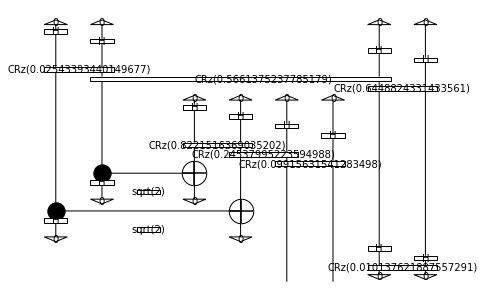

In [24]:
#intransitive sentence
func(psr_diagrams_dict['morose woman cries.']).draw()

We do the same for the remaining sentence types

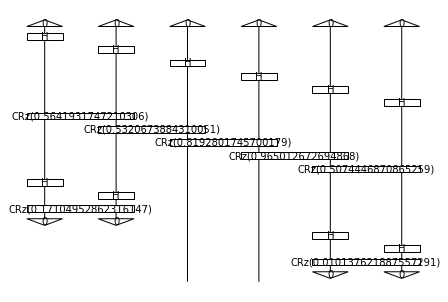

In [25]:
#basic transitive sentence
func(psr_diagrams_dict['man grieves woman.']).draw()

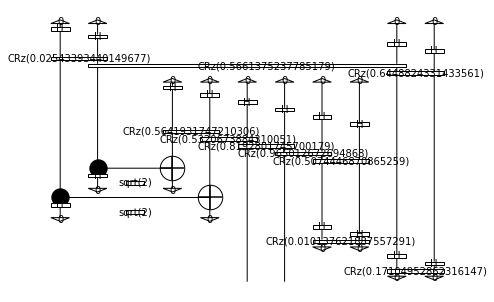

In [26]:
#transitive sentence, left adjective
func(psr_diagrams_dict['morose man grieves woman.']).draw()

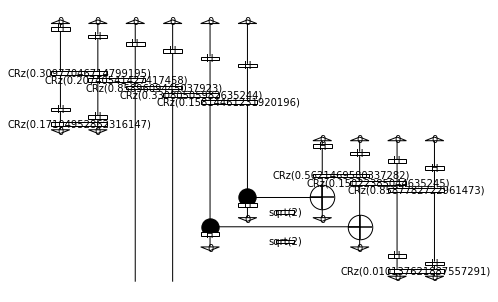

In [27]:
#transitive sentence, right adjective
func(psr_diagrams_dict['man entertains joyful woman.']).draw()

We are now ready to write a function to construct a circuit in qiskit

In [28]:
def get_qiskit_results(circ, sent, retries=10, qasm=False):
    """Function to get the Qiskit's results from a DisCoPy circuit.
    
    Args:
        circ: DisCoPy circuit.
        sent: English sentence corresponding to circuit
        retries: number of retries before assigning a random result
            if the postselection leads to zero values (Default is 10).
        qasm: if True qasm_simulator is used, if not statevector_simulator
            (Default is False).
            
    Returns:
        array: results from the postselection measurement.
    """
        
        
    #Finds the sentence's type to determine the number of qubits and position of the sentence qubits
    s_type = sent_type[sent]
    
    if s_type == 'int':
        n_qubits = 8
        posts = [4,5]
    elif s_type == 'tra':
        n_qubits = 6
        posts = [2,3]
    elif s_type == 'tra_l':
        n_qubits = 10
        posts = [4,5]
    else:
        assert s_type == 'tra_r'
        n_qubits = 10
        posts = [2,3]
    
    
    #the diagrams are initially in discopy, so we first convert them to tket and then to qiskit
    qc = tk_to_qiskit(circ.to_tk())
    
    if qasm == True:
        backend = Aer.get_backend('qasm_simulator')
        #qasm_simulator
        out_reg = ClassicalRegister(2)
        qc.add_register(out_reg)
        qc.measure(posts, out_reg) 
        if noise_model is not None:
            # Include noise model
            results = execute(qc, backend, shots=max_shots, noise_model=noise_model, 
                              coupling_map=coupling_map,basis_gates=basis_gates).result().get_counts()
        else:
            results = execute(qc, backend, shots=max_shots).result().get_counts()

        zeros = '0' * (n_qubits - 1)

        if '0 ' + zeros not in results and '1 ' + zeros not in results:
            if retries == 0:
                return np.random.rand(2)
            return get_qiskit_results(circ, s_type, transpile, retries=retries-1, qasm = qasm_bool)

        return parse_results(results, eff=zeros)
    
    
    else:

        qc.remove_final_measurements() 

        state_dict = Statevector(qc).to_dict()

        #The only values we care about are the ones when the non-sentence qubits are all zero. This leaves 4 possible values
        #for the sentence qubits, which we store in a list here
        selections = ['0' * posts[0] + val + '0' * (n_qubits - posts[1] - 1) for val in ['00', '01', '10', '11']]

        return [np.abs(state_dict[sel])**2 for sel in selections] #returns the amplitude of each of these four states
    

In [29]:
from qiskit.algorithms.optimizers import SPSA
import time

global_costs = [] #global variable to keep track of cost during training

begin_time = time.time()

def cost_ce(unshaped_params): #finds cross entropy cost
    
    #creates a functor which turns a sentence diagram into a circuit parameterized by unshaped_params
    func = F(reshape_params(unshaped_params, par_shapes)) 
    
    #Applies this functor to every training diagram
    circs = [func(diag) for diag in train_data_psr]
    
    #Finds the post-selected qiskit results for each circuit
    results = np.array([get_qiskit_results(circs[i], train_sent[i]) for i in range(len(train_sent))])

    #Turns each result into a probability distribution
    results_tweaked = [np.abs(np.array(res) - 1e-9) for res in results] 
    pred_labels_distrs = [res.flatten() / np.sum(res) for res in results_tweaked]
    
    
    #finds the cross entropy
    cross_entropies = np.array([np.sum(train_labels[s] * np.log2(pred_labels_distrs[s])) for s in range(len(train_labels))])
    cost = -1 / len(train_data_psr) * np.sum(cross_entropies)
    
    #stores the cost in a global list so we can track progress
    global_costs.append(cost)
    
    if len(global_costs) % 100 == 0: #since SPSA calls the cost function twice per iteration, this prints every 50 iterations
        print("at iteration", len(global_costs)/2, time.time() - begin_time)
       
    
    return cost


ps = {}

#Chooses random parameters to begin with
rand_unshaped_pars = randparams(par_shapes)
num_vars = len(rand_unshaped_pars)

#create bounds between 0 and 1 for every variable
bounds = [[0.0, 1.0] for _ in range(len(rand_unshaped_pars))]

n_iterations = 1250

a = time.time()

#creates a qiskit SPSA optimizer
opt = SPSA(maxiter=n_iterations)

print("\n\ncalibrating")
opt.calibrate(cost_ce, initial_point=rand_unshaped_pars) #calibrates it with the cost function and starting parameters
print("training")

global_costs = []
begin_time = time.time()

ps = opt.optimize(num_vars, cost_ce, initial_point=rand_unshaped_pars, variable_bounds=bounds)
print("took", time.time() - a)
pickle.dump([ps, global_costs], open("sentiment_analysis_qiskit_ce_1250.p", "wb"))



calibrating
training
at iteration 50.0 1303.121148109436
at iteration 100.0 2590.1141769886017
at iteration 150.0 3890.9484012126923
at iteration 200.0 5319.089219093323
at iteration 250.0 6966.421266317368
at iteration 300.0 8710.467033147812
at iteration 350.0 10401.640330314636
at iteration 400.0 12057.711717128754
at iteration 450.0 13954.548219203949
at iteration 500.0 15301.357259988785
at iteration 550.0 16986.312843084335
at iteration 600.0 18368.914495944977
at iteration 650.0 19659.06175994873
at iteration 700.0 21243.520938396454
at iteration 750.0 23456.11111807823
at iteration 800.0 25259.57592701912
at iteration 850.0 26795.84642624855
at iteration 900.0 28331.2482984066
at iteration 950.0 29943.572734355927
at iteration 1000.0 31549.124123096466
at iteration 1050.0 33141.194934129715
at iteration 1100.0 34734.74465203285
at iteration 1150.0 36314.6947221756
at iteration 1200.0 37901.865185022354
at iteration 1250.0 39464.44151234627
took 40990.17434120178


## 5. Results <a name="results"></a>


Having trained the model, we are now ready to analyze the results. First, we use the final parameters to construct a functor which can turn any sentence into a quantum circuit. Then we evaluate each of the test circuits against the test labels to find the final predictions.

In [35]:
func = F(reshape_params(ps[0], par_shapes))
    
circs = [func(diag) for diag in test_data_psr]
    
results = np.array([get_qiskit_results(circs[i], test_sent[i]) for i in range(len(test_sent))])

    
results_tweaked = [np.abs(np.array(res) - 1e-9) for res in results]
pred_labels_distrs = [res.flatten() / np.sum(res) for res in results_tweaked]

We output the confusion matrix and test accuracy

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

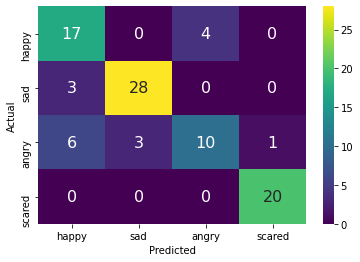

In [36]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

c_matrix = confusion_matrix([np.argmax(t) for t in test_labels], [np.argmax(r) for r in pred_labels_distrs])

df_cm = pd.DataFrame(c_matrix, ['happy','sad','angry','scared'], ['happy','sad','angry','scared'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='viridis',
                xticklabels=True, yticklabels=True)

In [40]:
print("test accuracy =", sum([np.argmax(test_labels[i]) == np.argmax(pred_labels_distrs[i]) for i in range(len(test_labels))])/len(test_labels))

test accuracy = 0.8152173913043478


We can also plot the cost over the course of training. We save the cost every time the cost function is called. Since calibration requires 51 calls and the cost function is called twice per iteration, we eliminiate the first 51 values and average the subsequent pairs

In [46]:
costs = global_costs[51:]
n = ps[-1]
costs = [(costs[j*2] + costs[j*2 + 1])/2 for j in range(n//2)]

Finally, we plot the cost during training 

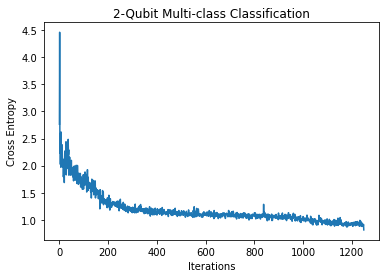

In [47]:
import matplotlib.pyplot as plt


plt.xlabel('Iterations')
plt.ylabel('Cross Entropy')
plt.title("2-Qubit Multi-class Classification")
plt.plot(costs)
